# Prune DistillBERT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [2]:
def reseed(seed, env=None):
    '''
        Sets the seed for reproducibility 

        When @param env is provided, also sets the 
        random number generataor of the gym environment 
        to this particular seed
    '''
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    if env is not None: 
        env.unwrapped._np_random = gym.utils.seeding.np_random(seed)[0]


### Load Dataset

https://huggingface.co/datasets/dair-ai/emotion


In [3]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizer, DistilBertModel

raw_dataset = load_dataset("dair-ai/emotion")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

C:\Users\kathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\datasets\load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\kathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kathe\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Make Dataloader / Data Preprocessing

In [4]:
from torch.utils.data import DataLoader

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding=True, return_tensors="pt", max_length=50)

tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def one_hot_encode(x, max_len=6):
    result = torch.zeros(max_len)
    result[x] = 1
    return result

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    labels = [one_hot_encode(item['label']) for item in batch]

    # Convert lists to tensors
    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    labels = torch.stack(labels)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=collate_fn)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8, collate_fn=collate_fn)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### DistillBERT Class

In [5]:
class DistilBERTClass(torch.nn.Module):
    """
    Code for parts of the initializations and from the forward pass were taken from: 
    https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=FeftvDhjDSPp
    
    Taunk, Dhaval. “Finetune DistilBERT for multi-label text classsification task.” Analytics Vidhya, Medium, 16 Sep. 2020
    """
    

    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)
        
        self.loss_history = []
        self.pruning_layers = ["l1.transformer.layer.0.ffn.lin1.weight", "l1.transformer.layer.0.ffn.lin1.bias",
        "l1.transformer.layer.0.ffn.lin2.weight", "l1.transformer.layer.0.ffn.lin2.bias",
        "l1.transformer.layer.1.ffn.lin1.weight", "l1.transformer.layer.1.ffn.lin1.bias",
        "l1.transformer.layer.1.ffn.lin2.weight", "l1.transformer.layer.1.ffn.lin2.bias",
        "l1.transformer.layer.2.ffn.lin1.weight", "l1.transformer.layer.2.ffn.lin1.bias",
        "l1.transformer.layer.2.ffn.lin2.weight", "l1.transformer.layer.2.ffn.lin2.bias",
        "l1.transformer.layer.3.ffn.lin1.weight", "l1.transformer.layer.3.ffn.lin1.bias", 
        "l1.transformer.layer.3.ffn.lin2.weight", "l1.transformer.layer.3.ffn.lin2.bias",
        "l1.transformer.layer.4.ffn.lin1.weight", "l1.transformer.layer.4.ffn.lin1.bias",
        "l1.transformer.layer.4.ffn.lin2.weight", "l1.transformer.layer.4.ffn.lin2.bias",
        "l1.transformer.layer.5.ffn.lin1.weight", "l1.transformer.layer.5.ffn.lin1.bias",
        "l1.transformer.layer.5.ffn.lin2.weight", "l1.transformer.layer.5.ffn.lin2.bias"]
        self.pretrained_weights_dict = self.get_param_dict()
        self.scores_dict = None

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    
    def get_param_list(self):
        """
        Get weights as numpy array
        """
        params = []
        for i, p in enumerate(self.named_parameters()):
            if p[0] in self.pruning_layers:
                params.extend(p[1].view(-1).cpu().detach().numpy())
        return np.array(params)

    def get_param_dict(self):
        """
        Get weights by layer as dictionary
        """
        params = {}
        for i, p in enumerate(self.named_parameters()):
            if p[0] in self.pruning_layers:
                temp = torch.clone(p[1]).cpu()
                params[p[0]] = temp
        return params

def train(model, data_loader, optimizer, criterion, num_epoch=1):
    
    model.train()
    for _ in range(num_epoch):
        for i, batch in tqdm(enumerate(data_loader, 0)):
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, mask)

            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if i%100==0:
                model.loss_history.append(loss.item())
                # print(f'Loss:  {loss.item()}')

def track_train(model, data_loader, optimizer, criterion, num_epoch=1):
    
    model.train()
    scores_dict = {k: None for k in model.pruning_layers}
    for _ in range(num_epoch):
        for i, batch in tqdm(enumerate(data_loader, 0)):
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, mask)

            before_weight_dict = model.get_param_dict()
            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            after_weight_dict = model.get_param_dict()

            with torch.no_grad():
                for k in before_weight_dict.keys():
                    if scores_dict[k] == None:
                        scores_dict[k] = (after_weight_dict[k] - before_weight_dict[k]) * before_weight_dict[k]
                    else:
                        scores_dict[k] += (after_weight_dict[k] - before_weight_dict[k]) * before_weight_dict[k]

            if i%100==0:
                model.loss_history.append(loss.item())

    model.scores_dict = scores_dict

from torcheval.metrics.functional import multiclass_f1_score
def evaluate(model, data_loader, criterion, plot=True):
    model.eval()
    predictions = []
    targets = []
    losses = []
    f1s = []
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        target = batch['labels'].to(device, dtype = torch.float)

        outputs = model(input_ids, mask)
        loss = criterion(outputs, target)
        losses.append(loss.item())
        # f1s.append(multiclass_f1_score(outputs, targets, num_classes=6))
        
        # preds = outputs.argmax(dim=1)
        # preds = preds.cpu().detach().numpy().tolist()

        predictions.extend(outputs.cpu().detach().numpy().tolist())
        targets.extend(target.cpu().detach().numpy().tolist())
    
    pred_labels = np.array(predictions).argmax(axis=1)
    target_labels = np.array(targets).argmax(axis=1)
    prop_correct = np.mean(pred_labels == target_labels)
    avg_loss = np.mean(losses)

    if plot:
        plt.hist(target_labels, alpha=0.2)
        plt.hist(pred_labels, alpha=0.2)
        plt.legend(labels=["True", "Predicted"])
        plt.title(f"Average {str(criterion)} : {round(avg_loss, 4)}, % Correct: {round(100*prop_correct, 4)}")
        plt.show()

    return predictions, targets, pred_labels, target_labels, prop_correct, avg_loss


### Adam Model

In [6]:
seed = 9
reseed(seed)

model = DistilBERTClass()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

untrained_weights_list = model.get_param_list()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

#### Evaluate Untrained Model

100%|██████████| 250/250 [00:06<00:00, 40.72it/s]


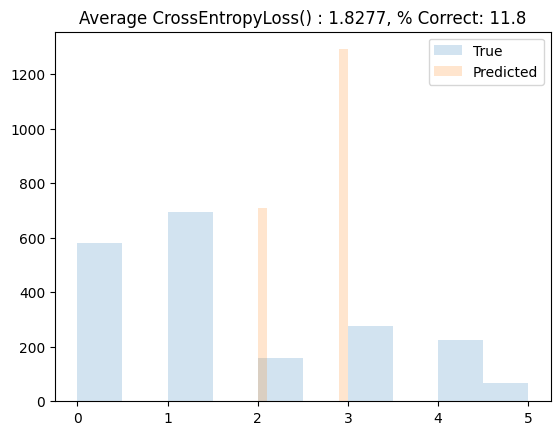

In [7]:
untrained_predictions, targets, untrained_pred_labels, target_labels, untrained_prop_correct, untrained_avg_loss  = evaluate(model, eval_dataloader, criterion)

In [8]:
# train(model, train_dataloader, optimizer, criterion, 1)
track_train(model, train_dataloader, optimizer, criterion, 1)

2000it [10:15,  3.25it/s]


Text(0, 0.5, 'CrossEntropyLoss()')

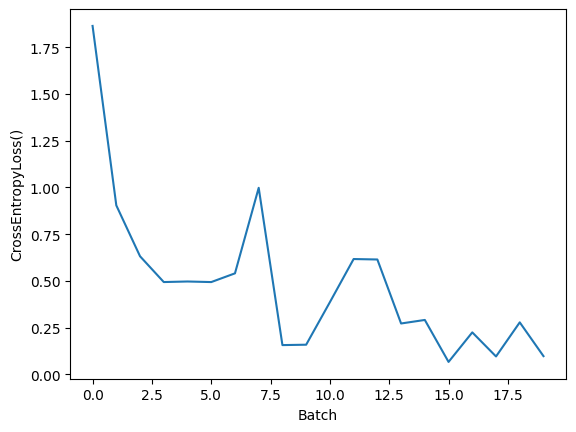

In [9]:

torch.save(model, 'adam_distilbert.pt')
trained_weights_list = model.get_param_list()

loss_history = model.loss_history
plt.plot(loss_history)
plt.xlabel("Batch")
plt.ylabel(str(criterion))

In [10]:
random_idx = np.random.choice(list(range(len(trained_weights_list))), 1000)

100%|██████████| 250/250 [00:07<00:00, 34.98it/s]


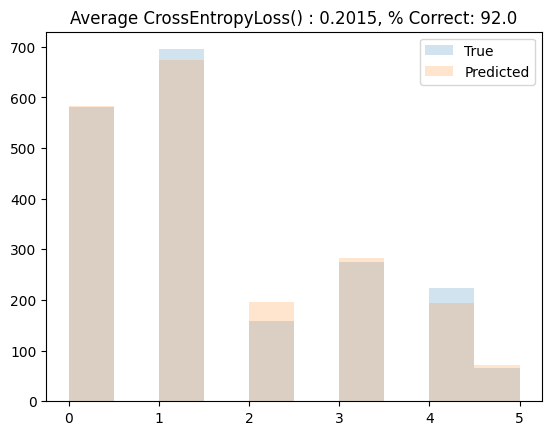

In [11]:
trained_predictions, targets, untrained_pred_labels, target_labels, untrained_prop_correct, untrained_avg_loss = evaluate(model, eval_dataloader, criterion)

### SGD

In [294]:
seed = 9
reseed(seed)

sgd_model = DistilBERTClass()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sgd_model.to(device)

optimizer = torch.optim.SGD(params = sgd_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=4)
criterion = nn.CrossEntropyLoss()

sgd_untrained_weights_list = sgd_model.get_param_list()

100%|██████████| 250/250 [00:05<00:00, 43.08it/s]


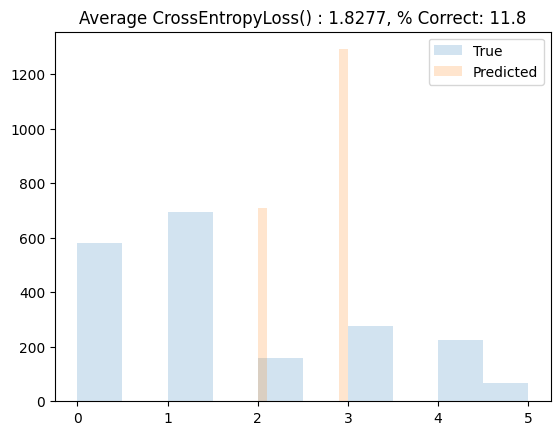

In [257]:
untrained_predictions, targets, untrained_pred_labels, target_labels, untrained_prop_correct, untrained_avg_loss  = evaluate(sgd_model, eval_dataloader, criterion)

In [297]:
for _ in range(3):
    train(sgd_model, train_dataloader, optimizer, criterion, 1)
    scheduler.step()

2000it [01:03, 31.65it/s]
2000it [01:00, 32.85it/s]
2000it [00:59, 33.44it/s]


Text(0, 0.5, 'CrossEntropyLoss()')

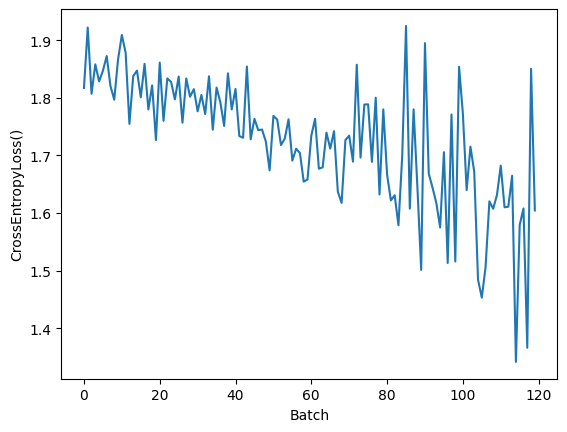

In [298]:
torch.save(model, 'sgd_distilbert.bin')
trained_weights_list = sgd_model.get_param_list()

loss_history = sgd_model.loss_history
plt.plot(loss_history)
plt.xlabel("Batch")
plt.ylabel(str(criterion))

100%|██████████| 250/250 [00:05<00:00, 42.29it/s]


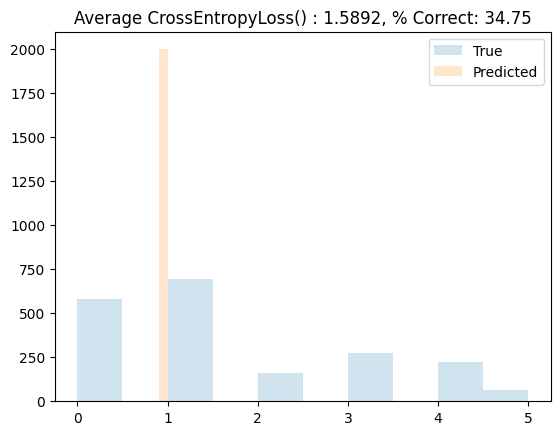

In [299]:
trained_predictions, targets, untrained_pred_labels, target_labels, untrained_prop_correct, untrained_avg_loss = evaluate(sgd_model, eval_dataloader, criterion)

### Masking

In [15]:
def get_masked_model(model, q=0.1, type="movement"):
    
    pretrained_weights_dict = model.pretrained_weights_dict
    fine_tuned_weights_dict = model.get_param_dict()
    state_dict = model.state_dict()

    device = pretrained_weights_dict[list(pretrained_weights_dict.keys())[0]].device

    mask_list = []
    score_list = []

    param_count = 0
    masked_param_count = 0
    for k in pretrained_weights_dict.keys():
        if type == "modified_movement":
            diff = fine_tuned_weights_dict[k] - pretrained_weights_dict[k]
            score = torch.abs(diff)
            # score = diff
            # score = diff * torch.sign(pretrained_weights_dict[k])
        elif type == "movement":
            # diff = fine_tuned_weights_dict[k].to(device) - pretrained_weights_dict[k].to(device)
            # score = diff * torch.mean(torch.stack((pretrained_weights_dict[k].to(device), fine_tuned_weights_dict[k].to(device)))) 
            score = -1 * model.scores_dict[k]
        elif type == "negative_movement":
            # diff = fine_tuned_weights_dict[k].to(device) - pretrained_weights_dict[k].to(device)
            # score = diff * torch.mean(torch.stack((pretrained_weights_dict[k].to(device), fine_tuned_weights_dict[k].to(device)))) 
            score = model.scores_dict[k]
        elif type == "random":
            score = torch.rand_like(fine_tuned_weights_dict[k])
        else: # magnitude pruning
            score = torch.abs(fine_tuned_weights_dict[k])

        flat_score = score.flatten()
        threshold = torch.quantile(flat_score, q)
        mask = score > threshold

        state_dict[k] = mask.to(device) * state_dict[k].to(device)

        param_count += len(flat_score)
        masked_param_count += torch.sum(mask.flatten())

        mask_list.extend(mask.flatten().cpu().detach().numpy())
        score_list.extend(flat_score.cpu().detach().numpy())
    
    percent_weight_removed = 1 - masked_param_count / param_count

    model.load_state_dict(state_dict)

    return model, percent_weight_removed.item(), np.array(mask_list), np.array(score_list)



In [13]:
model

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

#### Movement Pruned 🤨

In [45]:
q = 0.5
masked_model = torch.load('adam_distilbert.pt')
trained_weights_list = masked_model.get_param_list()
modified_movement_masked_model, modified_movement_percent_weight_removed, modified_movement_mask_list, modified_movement_score_list = get_masked_model(masked_model, q, "modified_movement")
modified_movement_pruned_weights_list = trained_weights_list[np.array(modified_movement_mask_list)]

100%|██████████| 250/250 [00:05<00:00, 45.44it/s]


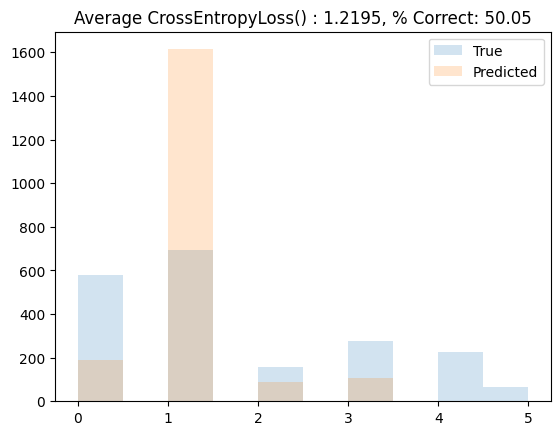

In [46]:
evaluate(modified_movement_masked_model, eval_dataloader, criterion)
plt.show()

In [47]:
q = 0.5
masked_model = torch.load('adam_distilbert.pt')
trained_weights_list = masked_model.get_param_list()
movement_masked_model, movement_percent_weight_removed, movement_mask_list, movement_score_list = get_masked_model(masked_model, q, type="movement")
movement_pruned_weights_list = trained_weights_list[np.array(movement_mask_list)]

100%|██████████| 250/250 [00:05<00:00, 45.32it/s]


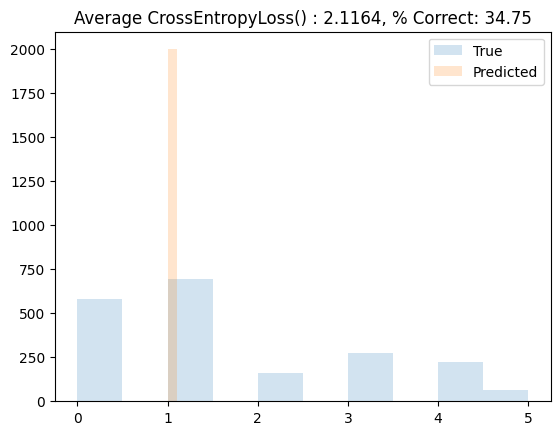

In [48]:
evaluate(movement_masked_model, eval_dataloader, criterion)
plt.show()

In [49]:
q = 0.5
masked_model = torch.load('adam_distilbert.pt')
trained_weights_list = masked_model.get_param_list()
negative_movement_masked_model, negative_movement_percent_weight_removed, negative_movement_mask_list, negative_movement_score_list = get_masked_model(masked_model, q, type="negative_movement")
negative_movement_pruned_weights_list = trained_weights_list[np.array(negative_movement_mask_list)]

100%|██████████| 250/250 [00:05<00:00, 45.13it/s]


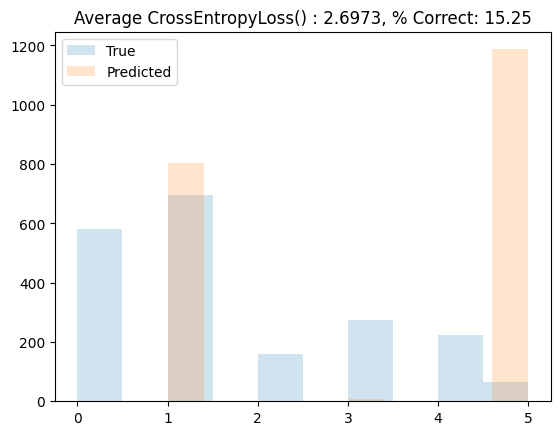

In [50]:
evaluate(negative_movement_masked_model, eval_dataloader, criterion)
plt.show()

#### Magnitude Pruned 😐

In [24]:
masked_model = torch.load('adam_distilbert.pt')
trained_weights_list = masked_model.get_param_list()
magnitude_masked_model, magnitude_percent_weight_removed, magnitude_mask_list, magnitude_score_list = get_masked_model(masked_model, q, type="magnitude")
magnitude_pruned_weights_list = trained_weights_list[np.array(magnitude_mask_list)]

100%|██████████| 250/250 [00:05<00:00, 43.64it/s]


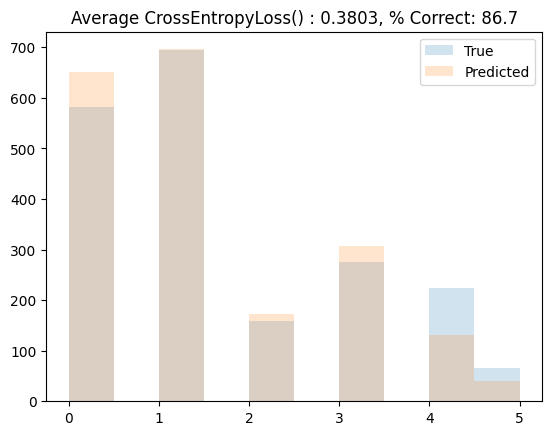

In [25]:
evaluate(magnitude_masked_model, eval_dataloader, criterion)
plt.show()

#### Random Pruned 😝

In [26]:
masked_model = torch.load('adam_distilbert.pt')
trained_weights_list = masked_model.get_param_list()
random_masked_model, random_percent_weight_removed, random_mask_list, random_score_list = get_masked_model(masked_model, q, type="random")
random_pruned_weights_list = trained_weights_list[np.array(random_mask_list)]

100%|██████████| 250/250 [00:05<00:00, 43.01it/s]


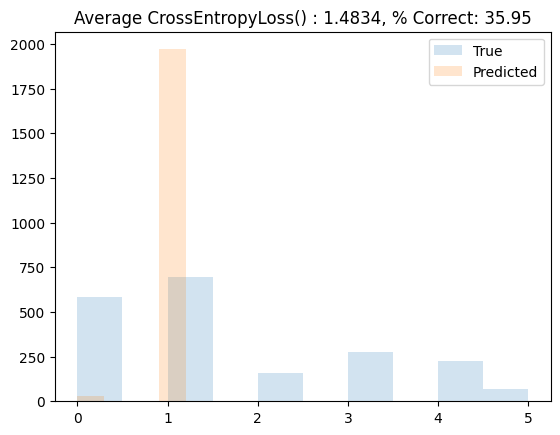

In [27]:
evaluate(random_masked_model, eval_dataloader, criterion)
plt.show()

#### Compare Weight Distributions

In [28]:
import seaborn as sns

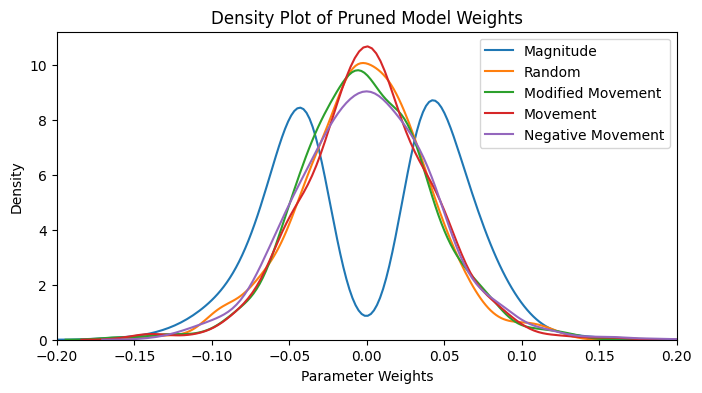

In [42]:

plt.figure(figsize=(8,4))
random_idx = np.random.choice(list(range(len(magnitude_pruned_weights_list))), 1000)

sns.kdeplot(magnitude_pruned_weights_list[random_idx], label="Magnitude")

sns.kdeplot(random_pruned_weights_list[random_idx], label="Random")

sns.kdeplot(modified_movement_pruned_weights_list[random_idx], label="Modified Movement")

# random_idx = np.random.choice(list(range(len(magnitude_pruned_weights_list))), 1000)

sns.kdeplot(movement_pruned_weights_list[random_idx], label="Movement")

sns.kdeplot(negative_movement_pruned_weights_list[random_idx], label="Negative Movement")


plt.xlim((-0.2, 0.2))
plt.xlabel("Parameter Weights")
plt.legend()
plt.title("Density Plot of Pruned Model Weights")
# plt.legend(labels = ["Movement", "Magnitude", "Random", "Movement Zero"])
plt.show()

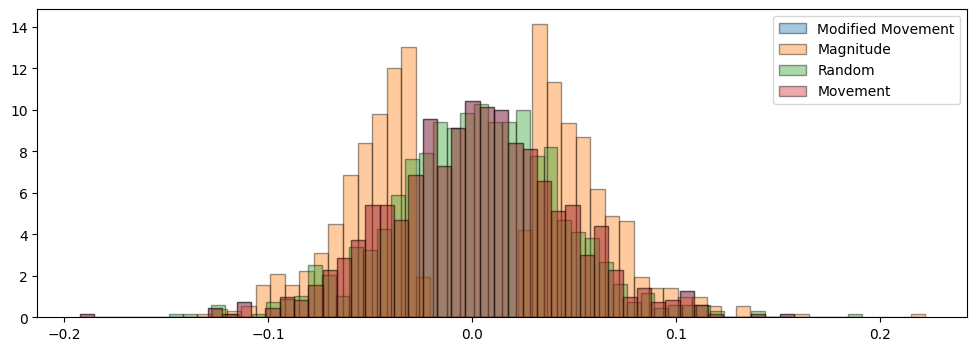

In [43]:

plt.figure(figsize=(12,4))
random_idx = np.random.choice(list(range(len(magnitude_pruned_weights_list))), 1000)
plt.hist(movement_pruned_weights_list[random_idx], bins=50, density=True, alpha=0.4, edgecolor="black")

# random_idx = np.random.choice(list(range(len(magnitude_pruned_weights_list))), 1000)
plt.hist(magnitude_pruned_weights_list[random_idx], bins=50, density=True, alpha=0.4, edgecolor="black")

plt.hist(random_pruned_weights_list[random_idx], bins=50, density=True, alpha=0.4, edgecolor="black")

plt.hist(movement_pruned_weights_list[random_idx], bins=50, density=True, alpha=0.4, edgecolor="black")

plt.legend(labels = ["Modified Movement", "Magnitude", "Random", "Movement"])
plt.show()

In [44]:
random_idx = np.random.choice(list(range(len(untrained_weights_list))), 10000)

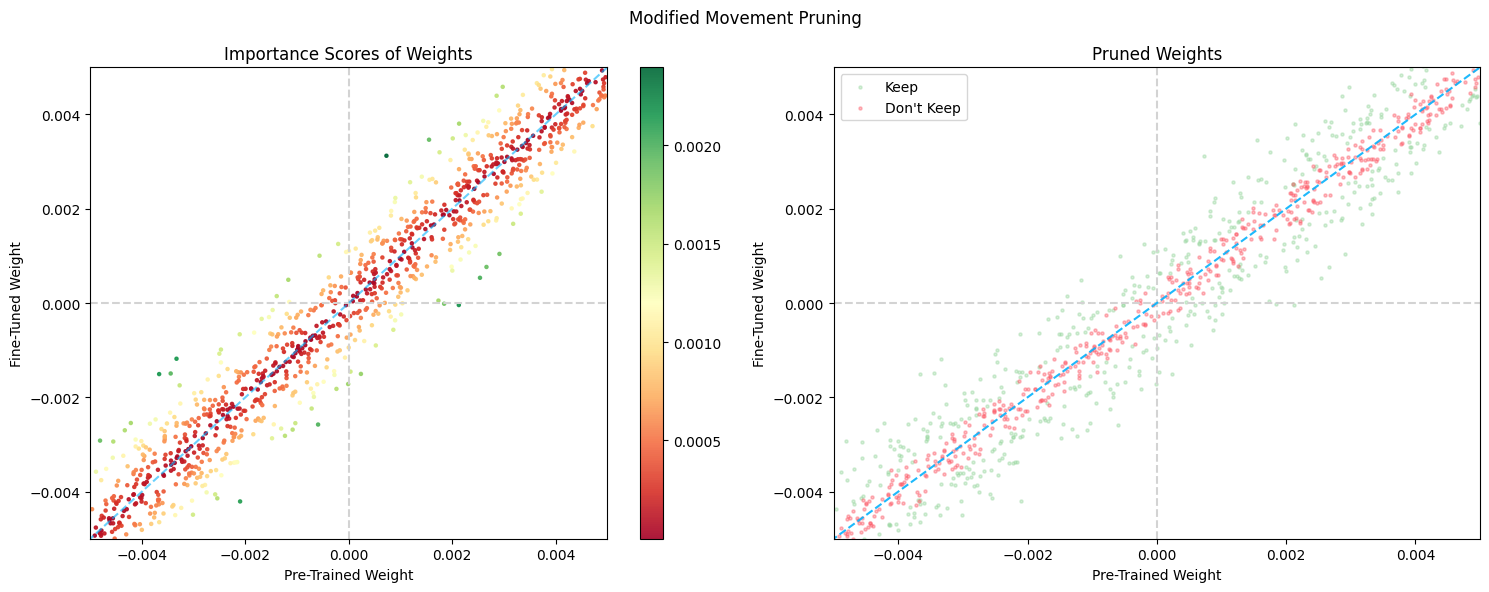

In [51]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = modified_movement_mask_list[random_idx]
score_subset = modified_movement_score_list[random_idx]

xy_subset = (x_subset < 0.005) & (x_subset > -0.005) & (y_subset < 0.005) & (y_subset > -0.005)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(x_subset[xy_subset], y_subset[xy_subset], s=5, alpha=0.9, c=score_subset[xy_subset], cmap='RdYlGn')
axs[0].axvline(x=0, color='lightgrey', linestyle='--')
axs[0].axhline(y=0, color='lightgrey', linestyle='--')
axs[0].set_xlabel("Pre-Trained Weight")
axs[0].set_ylabel("Fine-Tuned Weight")
axs[0].set_xlim((-0.005, 0.005))
axs[0].set_ylim((-0.005, 0.005))
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.6, color="#05b2fc", linestyle="--")
axs[0].set_title("Importance Scores of Weights")
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.4, color="#98d69f")
axs[1].scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.4,color="#fc5b68")
axs[1].axvline(x=0, color='lightgrey', linestyle='--')
axs[1].axhline(y=0, color='lightgrey', linestyle='--')
axs[1].set_xlabel("Pre-Trained Weight")
axs[1].set_ylabel("Fine-Tuned Weight")
axs[1].set_xlim((-0.005, 0.005))
axs[1].set_ylim((-0.005, 0.005))
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.9, color="#05b2fc", linestyle="--")
axs[1].legend(labels=["Keep", "Don't Keep"])
axs[1].set_title("Pruned Weights")

plt.suptitle("Modified Movement Pruning")

plt.tight_layout()
plt.show()


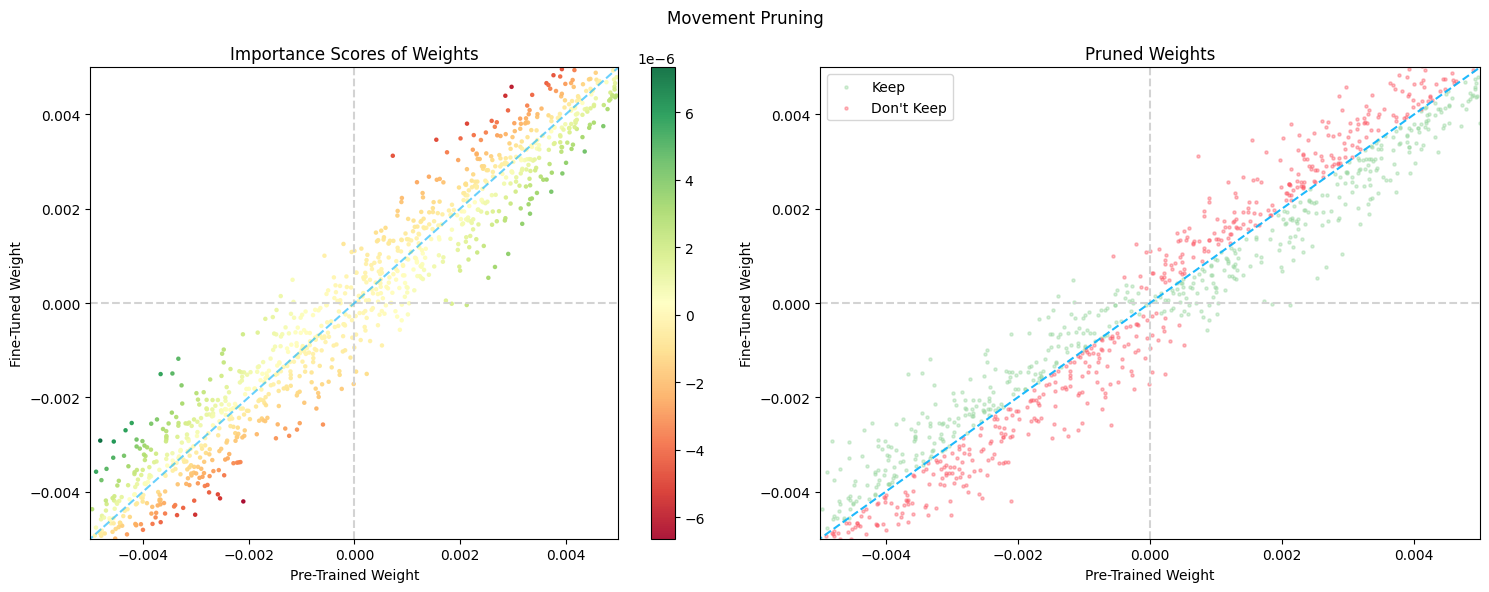

In [52]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = movement_mask_list[random_idx]
score_subset = movement_score_list[random_idx]

xy_subset = (x_subset < 0.005) & (x_subset > -0.005) & (y_subset < 0.005) & (y_subset > -0.005)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(x_subset[xy_subset], y_subset[xy_subset], s=5, alpha=0.9, c=score_subset[xy_subset], cmap='RdYlGn')
axs[0].axvline(x=0, color='lightgrey', linestyle='--')
axs[0].axhline(y=0, color='lightgrey', linestyle='--')
axs[0].set_xlabel("Pre-Trained Weight")
axs[0].set_ylabel("Fine-Tuned Weight")
axs[0].set_xlim((-0.005, 0.005))
axs[0].set_ylim((-0.005, 0.005))
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.6, color="#05b2fc", linestyle="--")
axs[0].set_title("Importance Scores of Weights")
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.4, color="#98d69f")
axs[1].scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.4,color="#fc5b68")
axs[1].axvline(x=0, color='lightgrey', linestyle='--')
axs[1].axhline(y=0, color='lightgrey', linestyle='--')
axs[1].set_xlabel("Pre-Trained Weight")
axs[1].set_ylabel("Fine-Tuned Weight")
axs[1].set_xlim((-0.005, 0.005))
axs[1].set_ylim((-0.005, 0.005))
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.9, color="#05b2fc", linestyle="--")
axs[1].legend(labels=["Keep", "Don't Keep"])
axs[1].set_title("Pruned Weights")

plt.suptitle("Movement Pruning")

plt.tight_layout()
plt.show()


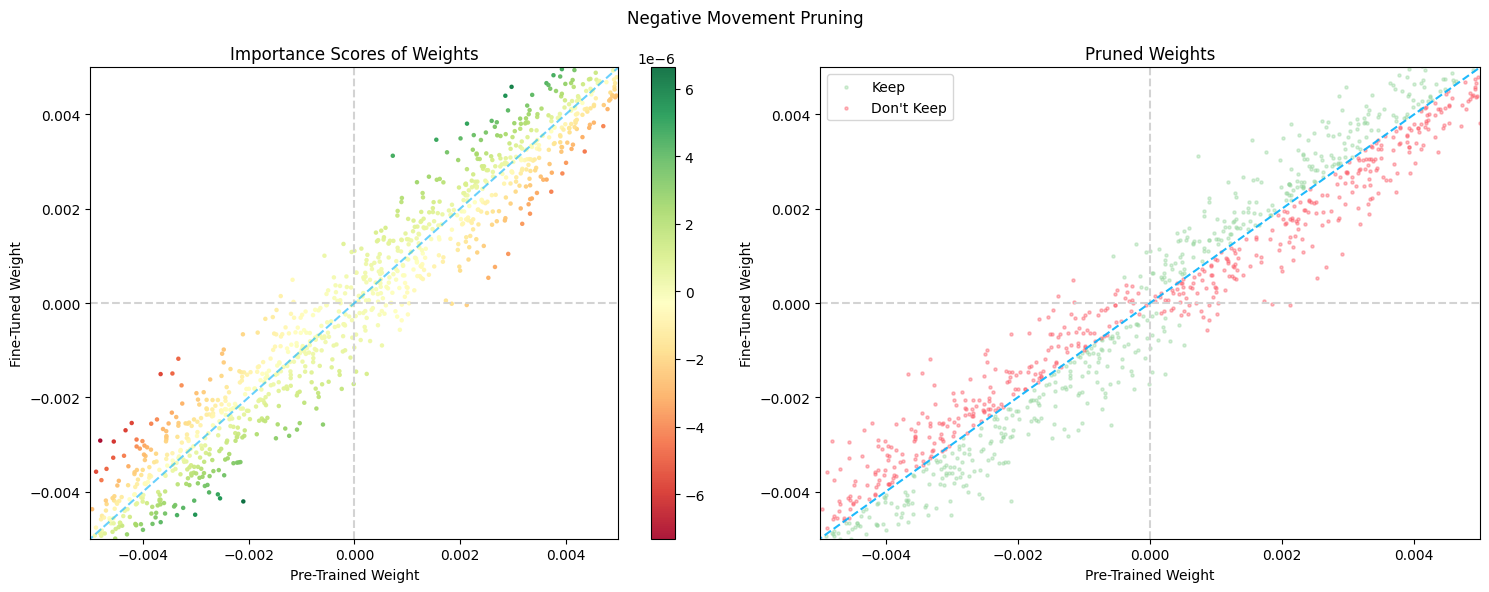

In [53]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = negative_movement_mask_list[random_idx]
score_subset = negative_movement_score_list[random_idx]

xy_subset = (x_subset < 0.005) & (x_subset > -0.005) & (y_subset < 0.005) & (y_subset > -0.005)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(x_subset[xy_subset], y_subset[xy_subset], s=5, alpha=0.9, c=score_subset[xy_subset], cmap='RdYlGn')
axs[0].axvline(x=0, color='lightgrey', linestyle='--')
axs[0].axhline(y=0, color='lightgrey', linestyle='--')
axs[0].set_xlabel("Pre-Trained Weight")
axs[0].set_ylabel("Fine-Tuned Weight")
axs[0].set_xlim((-0.005, 0.005))
axs[0].set_ylim((-0.005, 0.005))
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.6, color="#05b2fc", linestyle="--")
axs[0].set_title("Importance Scores of Weights")
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.4, color="#98d69f")
axs[1].scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.4,color="#fc5b68")
axs[1].axvline(x=0, color='lightgrey', linestyle='--')
axs[1].axhline(y=0, color='lightgrey', linestyle='--')
axs[1].set_xlabel("Pre-Trained Weight")
axs[1].set_ylabel("Fine-Tuned Weight")
axs[1].set_xlim((-0.005, 0.005))
axs[1].set_ylim((-0.005, 0.005))
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.9, color="#05b2fc", linestyle="--")
axs[1].legend(labels=["Keep", "Don't Keep"])
axs[1].set_title("Pruned Weights")

plt.suptitle("Negative Movement Pruning")

plt.tight_layout()
plt.show()


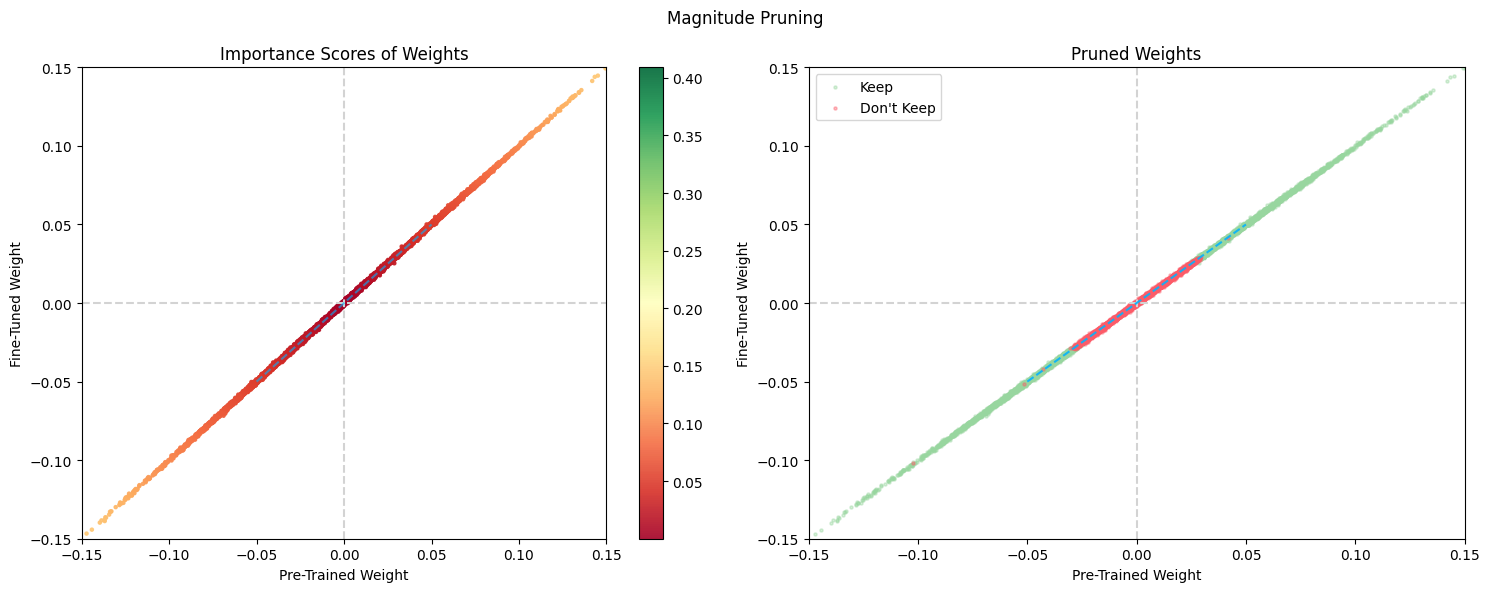

In [54]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = magnitude_mask_list[random_idx]
score_subset = magnitude_score_list[random_idx]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(x_subset, y_subset, s=5, alpha=0.9, c=score_subset, cmap='RdYlGn')
axs[0].axvline(x=0, color='lightgrey', linestyle='--')
axs[0].axhline(y=0, color='lightgrey', linestyle='--')
axs[0].set_xlabel("Pre-Trained Weight")
axs[0].set_ylabel("Fine-Tuned Weight")
axs[0].set_xlim((-0.15, 0.15))
axs[0].set_ylim((-0.15, 0.15))
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.6, color="#05b2fc", linestyle="--")
axs[0].set_title("Importance Scores of Weights")
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.4, color="#98d69f")
axs[1].scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.4,color="#fc5b68")
axs[1].axvline(x=0, color='lightgrey', linestyle='--')
axs[1].axhline(y=0, color='lightgrey', linestyle='--')
axs[1].set_xlabel("Pre-Trained Weight")
axs[1].set_ylabel("Fine-Tuned Weight")
axs[1].set_xlim((-0.15, 0.15))
axs[1].set_ylim((-0.15, 0.15))
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.9, color="#05b2fc", linestyle="--")
axs[1].legend(labels=["Keep", "Don't Keep"])
axs[1].set_title("Pruned Weights")

plt.suptitle("Magnitude Pruning")

plt.tight_layout()
plt.show()

In [55]:
import time

In [56]:
weight_removed_list = []
prop_correct_list = []
avg_loss_list = []
type_list = []

t1 = time.time()
types = ["modified_movement", "negative_movement", "movement", "magnitude", "random"]
for type in types:
    print(type)
    for q in tqdm(np.linspace(0.05, 0.95, 10)):
        masked_model = torch.load('adam_distilbert.pt')
        masked_model, percent_weight_removed, mask_list, score_list = get_masked_model(masked_model, q, type=type)
        masked_finetuned_weights_list = masked_model.get_param_list()
        masked_predictions, masked_targets, masked_pred_labels, masked_target_labels, masked_prop_correct, masked_avg_loss = evaluate(masked_model, eval_dataloader, criterion, plot=False)

        weight_removed_list.append(percent_weight_removed)
        prop_correct_list.append(masked_prop_correct)
        avg_loss_list.append(masked_avg_loss)
        type_list.append(type)

t2 = time.time()
print(t2-t1)

modified_movement


100%|██████████| 10/10 [03:26<00:00, 20.61s/it]


negative_movement


100%|██████████| 10/10 [03:37<00:00, 21.76s/it]


movement


100%|██████████| 10/10 [03:37<00:00, 21.78s/it]


magnitude


100%|██████████| 10/10 [03:37<00:00, 21.76s/it]


random


100%|██████████| 10/10 [03:41<00:00, 22.18s/it]

1080.841635465622


In [59]:
temp_df2 = pd.DataFrame({"weight_removed": weight_removed_list, "prop_correct": prop_correct_list, "avg_loss": avg_loss_list, "type":type_list})
temp_df2.to_csv("adam_pruning_performance4.csv")

In [60]:
temp_df = pd.read_csv("adam_pruning_performance4.csv")
temp_df = pd.concat([temp_df, temp_df2])
temp_df = temp_df.drop(columns=["Unnamed: 0"])
temp_df

,weight_removed,prop_correct,avg_loss,type
0,0.050001,0.9220,0.209235,modified_movement
1,0.150001,0.8840,0.354711,modified_movement
2,0.250001,0.7740,0.670989,modified_movement
3,0.350002,0.7240,0.852090,modified_movement
4,0.450001,0.5325,1.193622,modified_movement
...,...,...,...,...
45,0.550000,0.4775,1.506816,random
46,0.650000,0.4420,1.507135,random
47,0.750000,0.4185,1.473946,random
48,0.850000,0.3825,1.536014,random


In [61]:
temp_df = temp_df.sort_values("weight_removed").reset_index()

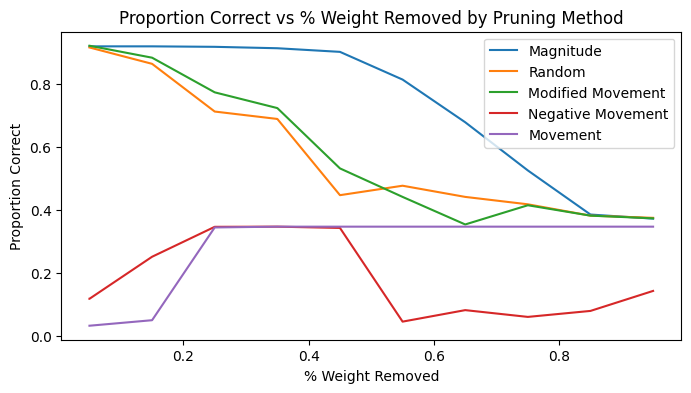

In [64]:
plt.figure(figsize=(8, 4))
types = ["magnitude", "random", "modified_movement", "negative_movement", "movement"]
type_labels = ["Magnitude", "Random", "Modified Movement", "Negative Movement", "Movement"]
for i in range(len(types)):
    subset = temp_df.loc[temp_df["type"] == types[i]]
    plt.plot(subset["weight_removed"], subset["prop_correct"], label=type_labels[i])

plt.xlabel("% Weight Removed")
plt.ylabel("Proportion Correct")
plt.title("Proportion Correct vs % Weight Removed by Pruning Method")
plt.legend()
plt.show()

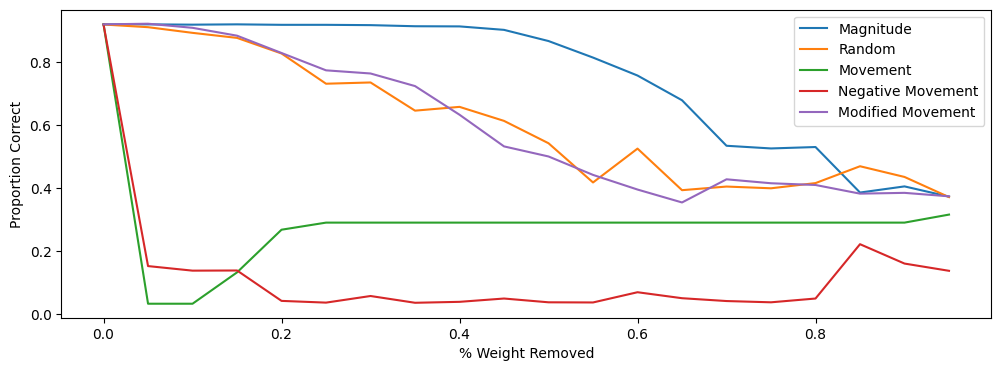

In [102]:

magnitude_df = temp_df.loc[temp_df["type"] == "magnitude"]
random_df = temp_df.loc[temp_df["type"] == "random"]
movement_df = temp_df.loc[temp_df["type"] == "movement_zero"]
negative_movement_zero_df = temp_df.loc[temp_df["type"] == "negative_movement"]
modified_movement_df = temp_df.loc[temp_df["type"] == "modified_movement"]

plt.figure(figsize=(8, 4))
plt.plot(magnitude_df["weight_removed"], magnitude_df["prop_correct"])
plt.plot(random_df["weight_removed"], random_df["prop_correct"])
plt.plot(movement_zero_df["weight_removed"], movement_zero_df["prop_correct"])
plt.plot(negative_movement_zero_df["weight_removed"], negative_movement_zero_df["prop_correct"])
plt.plot(movement_df["weight_removed"], movement_df["prop_correct"])

plt.xlabel("% Weight Removed")
plt.ylabel("Proportion Correct")
plt.legend(labels = ["Magnitude", "Random", "Movement", "Negative Movement", "Modified Movement"])
plt.show()


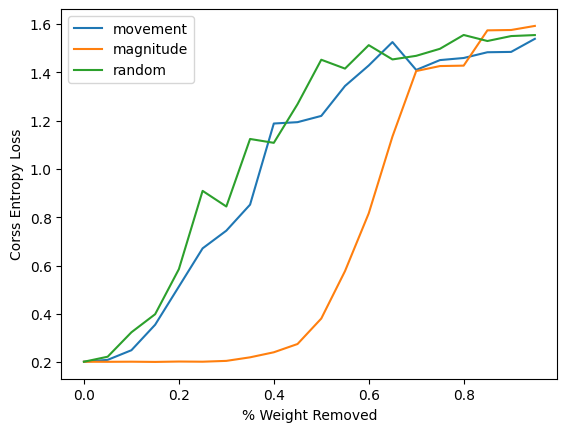

In [315]:
plt.plot(movement_df["weight_removed"], movement_df["avg_loss"])
plt.plot(magnitude_df["weight_removed"], magnitude_df["avg_loss"])
plt.plot(random_df["weight_removed"], random_df["avg_loss"])

plt.xlabel("% Weight Removed")
plt.ylabel("Corss Entropy Loss")
plt.legend(labels = ["movement", "magnitude", "random"])

In [47]:
# magnitude_weight_removed_list = []
# magnitude_prop_correct_list = []
# magnitude_avg_loss_list = []

for q in tqdm(np.linspace(0.5, 1, 15)):
    masked_model = torch.load('distilbert.pt')
    masked_model, percent_weight_removed, mask_list = get_masked_model(masked_model, q, type="magnitude")
    masked_finetuned_weights_list = masked_model.get_param_list()
    masked_predictions, masked_targets, masked_pred_labels, masked_target_labels, masked_prop_correct, masked_avg_loss = evaluate(masked_model, eval_dataloader, criterion, plot=False)

    magnitude_weight_removed_list.append(percent_weight_removed)
    magnitude_prop_correct_list.append(masked_prop_correct)
    magnitude_avg_loss_list.append(masked_avg_loss)

100%|██████████| 15/15 [04:13<00:00, 16.88s/it]


Text(0.5, 1.0, 'DistillBERT Classification Accuracy vs. Pruning')

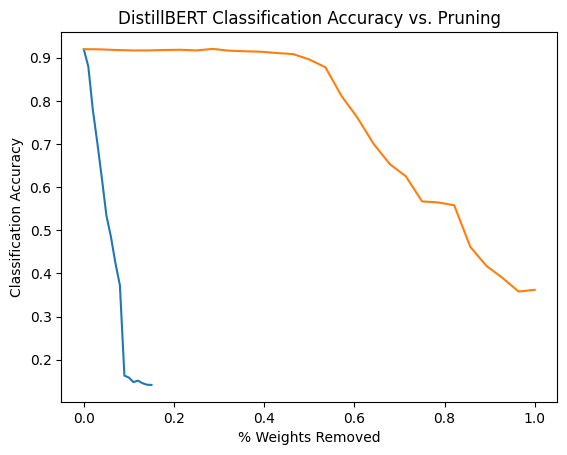

In [48]:
plt.plot(weight_removed_list, prop_correct_list)
plt.plot(magnitude_weight_removed_list, magnitude_prop_correct_list)

plt.xlabel("% Weights Removed")
plt.ylabel("Classification Accuracy")
plt.title("DistillBERT Classification Accuracy vs. Pruning")

Text(0.5, 1.0, 'DistillBERT Classification Accuracy vs. Pruning')

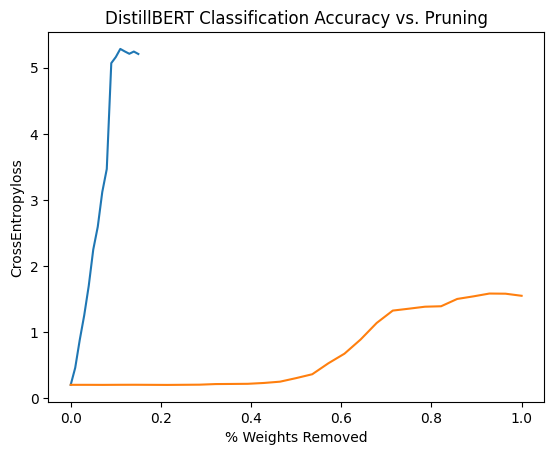

In [91]:
plt.plot(weight_removed_list, avg_loss_list)
plt.plot(magnitude_weight_removed_list, magnitude_avg_loss_list)

plt.xlabel("% Weights Removed")
plt.ylabel("CrossEntropyloss")
plt.title("DistillBERT Classification Accuracy vs. Pruning")

In [22]:
temp_df = pd.DataFrame({"weight_removed": weight_removed_list, "prop_correct": prop_correct_list, type:"Adam"})
temp_df.to_csv("Masked_Model_Performace.csv")